In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# I. Подготовка данных.

In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [5]:
df.set_index('ID', inplace=True)

In [6]:
df.select_dtypes(exclude='object').head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# II. Filter methods

## 1. Mutual information

In [8]:
mutual_information = mutual_info_classif(X, y)

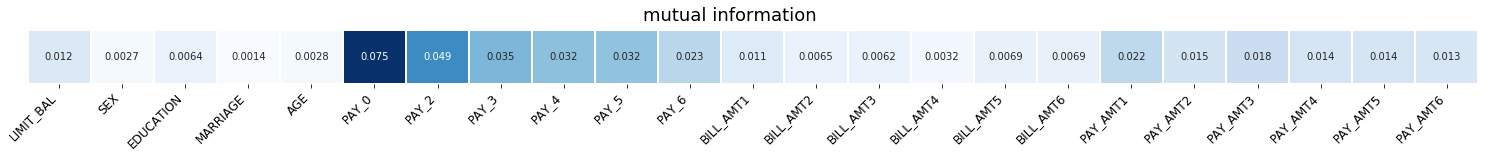

In [9]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information.reshape(1, -1), cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("mutual information", fontsize=18, y=1.2)
plt.show()

In [10]:
mutual_information_threshold = 0.01
X_new = X[X.columns[mutual_information > mutual_information_threshold]]

In [11]:
X_new.shape

(30000, 14)

In [12]:
def gini(target, feature):
    return 2*roc_auc_score(target, feature) - 1

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.3, random_state=42, stratify=y)

# III. Modeling

In [41]:
xgb_params = {
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist'
}

In [15]:
model = xgb.XGBClassifier(**xgb_params)

In [16]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_exact')

In [17]:
# %%time
# model.fit(X_new, y, early_stopping_rounds=10, eval_metric=['logloss', 'auc'], eval_set=[(X_train, y_train), (X_val, y_val)], 
#           verbose=True)

In [18]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
# param_grid = {
#                 'max_depth': [7, 9, 12, 15],
#                 'subsample': [0.7, 0.8, 0.9, 1],
#                 'colsample_bytree': [0.5, 0.8, 1],
#                 'colsample_bylevel': [0.5, 0.8, 1],
#                 'min_child_weight': [0.5, 1, 2, 5],
#     }

param_grid = {
                'max_depth': [4, 7, 9],
    }

In [20]:
# fit_params = {
#                 "early_stopping_rounds": 10, 
#                 "eval_metric": ['logloss', 'auc'], 
#                 "eval_set": [(X_train, y_train), (X_val, y_val)],
#                 'verbose': True
#     }

In [21]:
# grid_search = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', fit_params=fit_params, cv=skf.split(X_train, y_train), verbose=2)

In [22]:
model = xgb.XGBClassifier(**xgb_params)

In [23]:
grid_search = GridSearchCV(model, 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=skf, 
                           n_jobs=-1, 
                           verbose=3)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    7.8s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    9.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   10.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_exact'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 7, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=3)

In [25]:
grid_search.cv_results_['params'][grid_search.best_index_]

{'max_depth': 4}

In [26]:
grid_search.best_score_

0.7791103681991083

In [27]:
grid_search.cv_results_['split0_test_score'][grid_search.best_index_]

0.7788826199375073

In [28]:
grid_search.cv_results_['split1_test_score'][grid_search.best_index_]

0.7701263173460278

In [29]:
grid_search.cv_results_['split2_test_score'][grid_search.best_index_]

0.7883235160132294

In [30]:
grid_search.cv_results_

{'mean_fit_time': array([4.91434479, 6.68826723, 5.55167929]),
 'std_fit_time': array([0.34273492, 0.16891901, 1.83567838]),
 'mean_score_time': array([0.03257902, 0.02493302, 0.01861763]),
 'std_score_time': array([0.01429899, 0.00244367, 0.00554315]),
 'param_max_depth': masked_array(data=[4, 7, 9],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 4}, {'max_depth': 7}, {'max_depth': 9}],
 'split0_test_score': array([0.77888262, 0.77015157, 0.76395926]),
 'split1_test_score': array([0.77012632, 0.76443784, 0.7550346 ]),
 'split2_test_score': array([0.78832352, 0.78158104, 0.77562778]),
 'mean_test_score': array([0.77911037, 0.77205627, 0.76487332]),
 'std_test_score': array([0.00743046, 0.00712688, 0.00843164]),
 'rank_test_score': array([1, 2, 3]),
 'split0_train_score': array([0.83459465, 0.92158914, 0.96950619]),
 'split1_train_score': array([0.83664319, 0.92477529, 0.96763868]),
 'split2_train_score': array([0.

In [31]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_exact')

In [32]:
from sklearn.model_selection import cross_val_score, cross_validate

In [33]:
results = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

In [34]:
results

array([0.77888262, 0.77012632, 0.78832352])

In [36]:
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [38]:
cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)

In [39]:
cv_results 

{'fit_time': array([4.2399044 , 5.59627676, 4.57201433, 5.87752438, 4.90013862,
        5.5583837 , 5.51449227, 5.30705118, 3.8536942 , 4.72037578,
        4.07709503, 4.54085636, 4.12496495, 4.3264277 , 4.21572661,
        4.17882633, 3.16354084, 2.51228452, 2.31084824, 1.96175361]),
 'score_time': array([0.01296496, 0.01396227, 0.00997329, 0.01695418, 0.01495981,
        0.01196432, 0.03490615, 0.01097083, 0.00797915, 0.00897646,
        0.0079782 , 0.00797939, 0.00698137, 0.01296496, 0.01097059,
        0.01595783, 0.00997376, 0.00897646, 0.00898409, 0.00302768]),
 'test_score': array([0.79950576, 0.78365006, 0.74764421, 0.77942118, 0.77290209,
        0.79967699, 0.80246975, 0.7845539 , 0.7773533 , 0.75703197,
        0.75966402, 0.78785252, 0.76606631, 0.77718995, 0.7962598 ,
        0.80185603, 0.78235397, 0.7759201 , 0.79687038, 0.77249873]),
 'train_score': array([0.82242837, 0.82171051, 0.8237336 , 0.8217169 , 0.82265545,
        0.82063747, 0.82136766, 0.81937263, 0.82341124,

In [42]:
cv_results['test_score'].mean()

0.7810370513049764

In [ ]:
# col_list = X_new.columns.tolist()
# i = 1
# results = dict()
# results['iter_0'] = dict()
# results['iter_0']['all'] = grid_search.best_score_

# while len(col_list) > 1:
#     print('------------------------------------------------------------------------iter_' + str(i))
#     tmp_res = dict()
    
#     for col in tqdm(col_list):
#         print(col, '---------------------------------')
#         X_tmp = X_train[col_list].drop(col, axis=1)
#         candidate_model = xgb.XGBClassifier(**xgb_params)
#         candidate_grid_search = GridSearchCV(candidate_model, 
#                                             param_grid=param_grid, 
#                                             scoring='roc_auc', 
#                                             cv=skf,
#                                             n_jobs=-1, 
#                                             verbose=3)
#         candidate_grid_search.fit(X_tmp, y_train)
#         tmp_res[col] = candidate_grid_search.best_score_
    
#     col_to_be_dropped = max(tmp_res, key=tmp_res.get)       
#     col_list.remove(col_to_be_dropped)
#     results['iter_' + str(i)] = tmp_res
#     i += 1

In [43]:
skf_3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf_20 = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

In [ ]:
col_list = X_new.columns.tolist()
i = 1
results = dict()
results['stage_0'] = dict()
results['stage_0']['all'] = grid_search.best_score_

while len(col_list) > 1:
    print('------------------------------------------------------------------------stage_' + str(i))
    tmp_res = dict()
    
    for col in tqdm(col_list):
        print(col, '---------------------------------')
        X_tmp = X_train[col_list].drop(col, axis=1)
        
        candidate_model = xgb.XGBClassifier(**xgb_params)
        candidate_grid_search = GridSearchCV(candidate_model, 
                                            param_grid=param_grid, 
                                            scoring='roc_auc', 
                                            cv=skf_3,
                                            n_jobs=-1, 
                                            verbose=3)
        candidate_grid_search.fit(X_tmp, y_train)

        cv_results = cross_validate(candidate_grid_search.best_estimator_, X_tmp, y_train, 
                                    scoring='roc_auc', cv=skf_20, n_jobs=-1)
        tmp_res[col] = cv_results['test_score'].mean()
        
    col_to_be_dropped = max(tmp_res, key=tmp_res.get)       
    col_list.remove(col_to_be_dropped)
    results['stage_' + str(i)] = tmp_res
    i += 1

------------------------------------------------------------------------stage_1


LIMIT_BAL ---------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    8.6s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   20.2s remaining:   10.0s


In [114]:
pd.DataFrame(results)

,stage_0,stage_1,stage_2,stage_3,stage_4,stage_5,stage_6,stage_7,stage_8,stage_9,stage_10,stage_11,stage_12
LIMIT_BAL,NaN,0.776822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_0,NaN,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_2,NaN,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_3,NaN,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_4,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_5,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN,NaN
PAY_6,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN,NaN
PAY_AMT1,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN,NaN
PAY_AMT2,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN,NaN
PAY_AMT3,NaN,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,0.776822,NaN,NaN
